In [1]:
import time
import sys
import os

path_project = "\\".join(os.getcwd().split("\\")[:-1])
sys.path.insert(1, path_project)
import math
from hardware import config as hcf
import matplotlib.pyplot as plt
import numpy as np
import math
from hardware.pulser.pulser import PulseGenerator, OutputState, TriggerStart, TriggerRearm, HIGH, LOW, INF, REPEAT_INFINITELY
from hardware.laser.laser import LaserControl
from hardware.mw.mwsynthesizer import Synthesizer
from hardware.daq.sidig import FIFO_DataAcquisition, DCCOUPLE, TERMIN_INPUT_50OHM, TERMIN_INPUT_1MOHM
from spcm import units

In [2]:
def lcm(a, b):
    """Calculate the least common multiple of two numbers."""
    return abs(a * b) // math.gcd(a, b)

def seqtime_cb(seq_cb):
    return np.sum([pulse[-0] for pulse in seq_cb])

## Set up Connection with Devices

In [4]:
laser = LaserControl(hcf.LASER_SN)
laser.open()

uncal_choffset = {"laser":0, 
                "dclk":0, 
                "dtrig":0,
                "mwA":0, 
                "mwB":0,
                "sdtrig":0,
                }
ps = PulseGenerator(ip=hcf.PS_IP, 
                    chmap=hcf.PS_chmap,
                    choffs=uncal_choffset)

dig = FIFO_DataAcquisition(
                sn_address=hcf.SIDIG_ADDRESS
            )


Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 192.168.1.26
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
Clock mode set to: 32
1: Internal, 2: Quartz, 3: External, 32: Direct External Sampling


## Set Up Pulse Sequence

In [5]:
tb = lcm(hcf.SIDIG_timebase, hcf.PS_timebase)

t_laser = 4000
t_wait = 500
t_isc = 400
t_mw = 8000

t_dswait = t_wait
t_dstrig = 200
t_dspad = t_wait +t_laser+ t_isc - (t_dstrig +t_dswait)

seq_laser = [(t_mw, LOW), (t_wait, LOW), (t_laser, HIGH), (t_isc, LOW)]+[(t_mw, LOW), (t_wait, LOW), (t_laser, HIGH), (t_isc, LOW)]
# seq_mw = [(t_mw, HIGH), (t_wait + t_laser+ t_isc, LOW)] + [(t_mw, LOW), (t_wait + t_laser+ t_isc, LOW)]
seq_sdtrig =   [(t_mw, LOW), (t_dswait, LOW), (t_dstrig, HIGH), (t_dspad, LOW)]+[(t_mw, LOW), (t_dswait, LOW), (t_dstrig, HIGH), (t_dspad, LOW)]

t_seq = seqtime_cb(seq_laser)


In [6]:
ps.reset()
ps.setDigital("laser", seq_laser)
# ps.setDigital("mwA", seq_mw)
ps.setDigital("sdtrig", seq_sdtrig)
ps.plotSeq()

In [7]:
ps.setTrigger(TriggerStart.SOFTWARE, rearm=TriggerRearm.AUTO)
ps.stream(n_runs=REPEAT_INFINITELY)

## Data Acquisition with Digitizer


In [10]:
# min_volt = -0.002 # [V]
# max_volt = 0.010 # [V]
rate_refresh = 10 # Hz rate of refreshing the data streaming
amp_input = 1000
readout_ch = hcf.SIDIG_chmap["apd"]
num_segment = int(2/rate_refresh*1e9/t_seq)//32*32

pretrig_size=int((t_wait/2)*hcf.SIDIG_maxsr/1E9)//64*64
posttrig_size=int((t_laser+t_isc)*hcf.SIDIG_maxsr/1E9)//64*64
segment_size = pretrig_size+posttrig_size
segment_size = 2**int(np.log2(segment_size)+1)
posttrig_size = segment_size-pretrig_size

In [17]:
pretrig_size*2

128

In [11]:
# To set the configuration, make a dictionary with the key and value
dig.reset_param()
dig.assign_param(dict(
             readout_ch=readout_ch, 
             amp_input=amp_input, 
             num_segment=num_segment,
             pretrig_size=pretrig_size,
             posttrig_size=posttrig_size,
             segment_size=segment_size,
             terminate_input=TERMIN_INPUT_1MOHM,
             ))


## Set Laser Diode Current

In [12]:
laser_curent = 35.01  #percent
laser.laser_off()
laser.set_analog_control_mode("current")
laser.set_modulation_state("Pulsed")
laser.set_diode_current(laser_curent, save_memory=False)
laser.laser_on() # turn on laser

In [13]:
dig.set_config()
dig.start_buffer()
ps.startNow()
time_stop = 1
time_start = time.time()
data_buffer_bright1 = np.zeros((segment_size))
data_buffer_bright2 = np.zeros((segment_size))
num_repeat = 0
while time.time()-time_start < time_stop:
    rawraw = dig.stream()
    if rawraw is not None:
        num_segs = np.shape(rawraw)[0]
        assert num_segs % 2 == 0
        rawraw_bright1 = rawraw[0::2, :, :]
        rawraw_bright2 = rawraw[1::2, :, :]
        data_buffer_bright1 += np.ravel(np.sum(rawraw_bright1, axis=0))
        data_buffer_bright2 += np.ravel(np.sum(rawraw_bright2, axis=0))
        num_repeat += num_segs//2
    # print(data_buffer)
    # print(data_buffer.shape)
data_buffer_bright1 = data_buffer_bright1/num_repeat
data_buffer_bright2 = data_buffer_bright2/num_repeat
laser.laser_off()
dig.stop_card()
# dig.reset()
ps.forceFinal()
ps.reset()


Card stopped


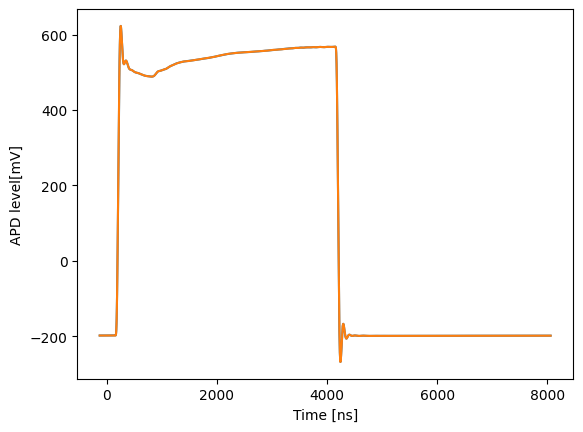

In [14]:
import matplotlib.pyplot as plt
tt = np.arange(-pretrig_size*hcf.SIDIG_timebase, posttrig_size*hcf.SIDIG_timebase, hcf.SIDIG_timebase)
# plt.plot(tt, data_buffer/128*1000)
plt.plot(tt, data_buffer_bright1*1000)
plt.plot(tt, data_buffer_bright2*1000)
plt.xlabel("Time [ns]")
plt.ylabel("APD level[mV]")
plt.show()

In [15]:
import plotly.graph_objects as go
import numpy as np

# Create time array
tt = np.arange(-pretrig_size * hcf.SIDIG_timebase, posttrig_size * hcf.SIDIG_timebase, hcf.SIDIG_timebase)

# Create figure
fig = go.Figure()

# Add traces for dark and bright data
fig.add_trace(go.Scatter(x=tt, y=data_buffer_bright1 * 1000, mode='lines', name='Brigth1 Signal'))
fig.add_trace(go.Scatter(x=tt, y=data_buffer_bright2 * 1000, mode='lines', name='Bright2 Signal'))
fig.add_trace(go.Scatter(x=tt, y=(data_buffer_bright2-data_buffer_bright1) * 1000, mode='lines', name='Diff'))


# Customize layout
fig.update_layout(
    title="APD Signal Over Time",
    xaxis_title="Time [ns]",
    yaxis_title="APD Level [mV]",
    # template="plotly_bright1",
    legend=dict(x=0, y=1)  # Adjust legend position
)

# Show plot
fig.show()
